In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
from dichotomous_multiplication_model_functions import *

In [3]:
index_cols=['location_id','sex_id','age_group_id']

age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8,1]
years = [2021,2022,2023,2024,2025]

In [4]:
# vitamin A specific -- these should be replaced for other models
rei_id = 96
cause_ids = [389, 302, 341]
nonfatal_causes = [389]
nutrient = 'vitamin a'
vehicle = 'oil'

effective_fractions = [0, 0, (365 - (365 * 0.5)) / (365 - 28), 1]

data = pd.read_csv(
        '/ihme/homes/alibow/notebooks/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/LSFF_extraction_clean_data_rich_locations_01_11_2021.csv')
location_ids = list(data.loc[data.nutrient==nutrient].loc[data.vehicle==vehicle].location_id.unique())

"""Note: full set of location IDs is shown below, but subset used here
was selected because they are the locations with non-missing coverage data
for the nutrient and vehicle of interest (vitamin A/oil)

[168, 161, 201, 202, 6, 205, 171, 141, 179, 207, 163, 11, 180, 181,
184, 15, 164, 213, 214, 165, 196, 522, 190, 189, 20]"""

location_ids

[163, 214, 205, 190, 189]

In [5]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 2.22
q_975 = 5.26

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [6]:
baseline_coverage, counterfactual_coverage = generate_overall_coverage_rates(nutrient, 
                                                                             vehicle,
                                                                             coverage_levels,
                                                                             years,
                                                                             location_ids)

In [7]:
# NOTE: the following functions are vitamin A specific and should not be used universally
# the coverage functions above assume that all coverage is effective coverage and can be used universally given this assumption

baseline_effective_coverage = get_effective_vitamin_a_coverage(baseline_coverage, 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)
counterfactual_effective_coverage = get_effective_vitamin_a_coverage(counterfactual_coverage, 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)

In [8]:
rr_deficiency_nofort = generate_rr_deficiency_nofort_draws(mu, sigma, location_ids)
rr_deficiency_nofort.mean(axis=1)

location_id
163    2.396239
214    2.396239
205    2.396239
190    2.396239
189    2.396239
dtype: float64

In [9]:
paf_dalys_deficiency = pull_cause_specific_dalys_deficiency_pafs(rei_id, 
                                                                 cause_ids, 
                                                                 location_ids, 
                                                                 age_group_ids, 
                                                                 sex_ids, 
                                                                 index_cols)
paf_dalys_deficiency.head()

draw_0    draw_1   draw_10  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.023614  0.022761  0.032084   
                                341       0.062437  0.068525  0.080122   
                                389       1.000000  1.000000  1.000000   

                                          draw_100  draw_101  draw_102  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.061713  0.010529  0.016051   
                                341       0.158759  0.013909  0.026354   
                                389       1.000000  1.000000  1.000000   

                                          draw_103  draw_104  draw_105  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.008245  0.045553  0.027902   
                                341       0.011891  0.113604  0.067258   
                                389       1.000000  1.000000  1.000000   

                                          draw_106  ...  draw_990  draw_991  \
location_id sex_id age_group_id cause_id            ...                       
163         1      2            389       1.000000  ...  1.000000  1.000000   
                   3            389       1.000000  ...  1.000000  1.000000   
                   4            302       0.032493  ...  0.013291  0.040655   
                                341       0.091411  ...  0.028041  0.109343   
                                389       1.000000  ...  1.000000  1.000000   

                                          draw_992  draw_993  draw_994  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.013134  0.040318  0.050091   
                                341       0.039931  0.107498  0.148924   
                                389       1.000000  1.000000  1.000000   

                                          draw_995  draw_996  draw_997  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.018375  0.019796  0.037472   
                                341       0.044538  0.046736  0.096353   
                                389       1.000000  1.000000  1.000000   

                                          draw_998  draw_999  
location_id sex_id age_group_id cause_id                      
163         1      2            389       1.000000  1.000000  
                   3            389       1.000000  1.000000  
                   4            302       0.025155  0.009430  
                                341       0.066101  0.021711  
                                389       1.000000  1.000000  

[5 rows x 1000 columns]

In [10]:
dalys = pull_dalys(cause_ids,
                   nonfatal_causes,
                   location_ids, 
                   age_group_ids, 
                   sex_ids, 
                   index_cols)
dalys.head()

/ihme/homes/alibow/notebooks/vivarium_data_analysis/pre_processing/lsff_project/multiplication_models/dichotomous_models/dichotomous_multiplication_model_functions.py:250: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  ylls = pd.concat([ylls.reset_index(), nonfatal.reset_index()]).set_index(index_cols + ['cause_id'])


draw_0         draw_1  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       228052.286761  256459.736242   
                                341            0.000000       0.000000   
                                389          249.085991     270.466085   
                   3            302       207609.552344  263078.492814   
                                341            0.000000       0.000000   

                                                draw_10       draw_100  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       146290.339705  192676.381120   
                                341            0.000000       0.000000   
                                389          270.284907     146.168022   
                   3            302       198861.237612  173638.640755   
                                341            0.000000       0.000000   

                                               draw_101       draw_102  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       172362.436243  187454.984499   
                                341            0.000000       0.000000   
                                389          118.041018     158.115471   
                   3            302       255710.254455  184070.329711   
                                341            0.000000       0.000000   

                                               draw_103       draw_104  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       159534.221668  176235.755329   
                                341            0.000000       0.000000   
                                389          160.563119     111.986426   
                   3            302       167459.228561  282709.744663   
                                341            0.000000       0.000000   

                                               draw_105       draw_106  ...  \
location_id sex_id age_group_id cause_id                                ...   
163         1      2            302       170489.703795  151586.434309  ...   
                                341            0.000000       0.000000  ...   
                                389          347.919477     159.200861  ...   
                   3            302       228526.429634  190682.116226  ...   
                                341            0.000000       0.000000  ...   

                                               draw_990       draw_991  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       233728.203639  195240.822126   
                                341            0.000000       0.000000   
                                389           87.646759     195.252324   
                   3            302       266360.552338  251853.188296   
                                341            0.000000       0.000000   

                                               draw_992       draw_993  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       264767.777947  189854.851927   
                                341            0.000000       0.000000   
                                389          129.934700     254.856255   
                   3            302       250290.066661  189621.733181   
                                341            0.000000       0.000000   

                                               draw_994       draw_995  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       201259.960318  246817.767701   
                                341            0.000000       0.000000   
                                389           47.148614     134.662517   
           

In [11]:
paf_deficiency_nofort = calculate_paf_deficiency_nofort(rr_deficiency_nofort, 
                                                        baseline_effective_coverage)
paf_deficiency_nofort.head()

draw_0    draw_1   draw_10  draw_100  \
location_id sex_id age_group_id year                                          
163         1      2            2021  0.78595  0.447022  0.406811  0.340996   
                                2022  0.78595  0.447022  0.406811  0.340996   
                                2023  0.78595  0.447022  0.406811  0.340996   
                                2024  0.78595  0.447022  0.406811  0.340996   
                                2025  0.78595  0.447022  0.406811  0.340996   

                                      draw_101  draw_102  draw_103  draw_104  \
location_id sex_id age_group_id year                                           
163         1      2            2021  0.617978  0.620854  0.149863  0.636347   
                                2022  0.617978  0.620854  0.149863  0.636347   
                                2023  0.617978  0.620854  0.149863  0.636347   
                                2024  0.617978  0.620854  0.149863  0.636347   
                                2025  0.617978  0.620854  0.149863  0.636347   

                                      draw_105  draw_106  ...  draw_990  \
location_id sex_id age_group_id year                      ...             
163         1      2            2021  0.421241  0.759597  ...  0.507946   
                                2022  0.421241  0.759597  ...  0.507946   
                                2023  0.421241  0.759597  ...  0.507946   
                                2024  0.421241  0.759597  ...  0.507946   
                                2025  0.421241  0.759597  ...  0.507946   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id sex_id age_group_id year                                           
163         1      2            2021  0.455066  0.740104  0.785748  0.396677   
                                2022  0.455066  0.740104  0.785748  0.396677   
                                2023  0.455066  0.740104  0.785748  0.396677   
                                2024  0.455066  0.740104  0.785748  0.396677   
                                2025  0.455066  0.740104  0.785748  0.396677   

                                      draw_995  draw_996  draw_997  draw_998  \
location_id sex_id age_group_id year                                           
163         1      2            2021  0.557149   0.64751  0.441514  0.406003   
                                2022  0.557149   0.64751  0.441514  0.406003   
                                2023  0.557149   0.64751  0.441514  0.406003   
                                2024  0.557149   0.64751  0.441514  0.406003   
                                2025  0.557149   0.64751  0.441514  0.406003   

                                      draw_999  
location_id sex_id age_group_id year            
163         1      2            2021  0.393076  
                                2022  0.393076  
                                2023  0.393076  
                                2024  0.393076  
                                2025  0.393076  

[5 rows x 1000 columns]

In [12]:
pif_deficiency_nofort = calculate_pif_deficiency_nofort(paf_deficiency_nofort, 
                                                        baseline_effective_coverage, 
                                                        counterfactual_effective_coverage)

assert np.all(pif_deficiency_nofort <= 1), "ERROR: PIFs outside of 0-1 bounds"

pif_deficiency_nofort.head()

draw_0  draw_1  draw_10  \
location_id sex_id age_group_id year coverage_level                            
163         1      2            2021 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   
                                     0.8                0.0     0.0      0.0   
                                     1.0                0.0     0.0      0.0   
                                2022 0.2                0.0     0.0      0.0   

                                                     draw_100  draw_101  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                     1.0                  0.0       0.0   
                                2022 0.2                  0.0       0.0   

                                                     draw_102  draw_103  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                     1.0                  0.0       0.0   
                                2022 0.2                  0.0       0.0   

                                                     draw_104  draw_105  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                     1.0                  0.0       0.0   
                                2022 0.2                  0.0       0.0   

                                                     draw_106  ...  draw_990  \
location_id sex_id age_group_id year coverage_level            ...             
163         1      2            2021 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   
                                     0.8                  0.0  ...       0.0   
                                     1.0                  0.0  ...       0.0   
                                2022 0.2                  0.0  ...       0.0   

                                                     draw_991  draw_992  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                     1.0                  0.0       0.0   
                                2022 0.2                  0.0       0.0   

                                                     draw_993  draw_994  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                     1.0                  0.0       0.0   
                                2022 0.2                  0.0       0.0   

                                                     draw_995  draw_996  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
 

In [13]:
pif_dalys_nofort, daly_reduction = calculate_final_pifs_and_daly_reductions(pif_deficiency_nofort, 
                                             paf_dalys_deficiency, 
                                             dalys, 
                                             coverage_levels,
                                             years)

In [14]:
fort_daly_reduction_by_location = (daly_reduction.groupby(['location_id','coverage_level','year']).sum()
                                   .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
                                   .filter(['mean','2.5%','97.5%']))
    
fort_daly_reduction_by_location

mean          2.5%         97.5%
location_id coverage_level year                                          
163         0.2            2021      0.000000      0.000000      0.000000
                           2022  -4489.645387 -10739.466898    215.817765
                           2023  -7696.534949 -18410.514682    369.973312
                           2024  -7696.534949 -18410.514682    369.973312
                           2025  -7696.534949 -18410.514682    369.973312
...                                       ...           ...           ...
214         1.0            2021      0.000000      0.000000      0.000000
                           2022  13483.990750  -1059.296424  35010.144451
                           2023  23115.412714  -1815.936726  60017.390488
                           2024  23115.412714  -1815.936726  60017.390488
                           2025  23115.412714  -1815.936726  60017.390488

[100 rows x 3 columns]

In [15]:
pop = (get_population(location_id=location_ids,
                    sex_id=sex_ids,
                    age_group_id=age_group_ids,
                    gbd_round_id=6,
                    decomp_step='step4')
       .groupby('location_id').sum())
rates = pop.reset_index().merge(fort_daly_reduction_by_location.reset_index(), on='location_id')
for col in ['mean','2.5%','97.5%']:
    rates[f'{col}'] = rates[f'{col}'] / rates.population * 100_000
rates = rates[['location_id','year','coverage_level','mean','2.5%','97.5%']]
l = get_ids('location')
l = l[l['location_id'].isin(location_ids)]
l = l[['location_id','location_name']]
rates = rates.merge(l, on='location_id')
rates

,location_id,year,coverage_level,mean,2.5%,97.5%,location_name
0,163,2021,0.2,0.000000,0.000000,0.000000,India
1,163,2022,0.2,-3.834984,-9.173483,0.184348,India
2,163,2023,0.2,-6.574259,-15.725972,0.316025,India
3,163,2024,0.2,-6.574259,-15.725972,0.316025,India
4,163,2025,0.2,-6.574259,-15.725972,0.316025,India
...,...,...,...,...,...,...,...
95,214,2021,1.0,0.000000,0.000000,0.000000,Nigeria
96,214,2022,1.0,40.224737,-3.160038,104.440435,Nigeria
97,214,2023,1.0,68.956692,-5.417208,179.040746,Nigeria
98,214,2024,1.0,68.956692,-5.417208,179.040746,Nigeria


Text(0, 0.5, 'DALYs Averted per 100,000')

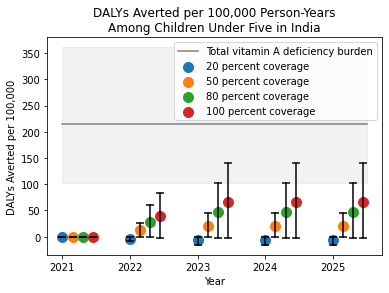

In [17]:
colors = ['tab:blue','tab:orange','tab:green']
location_id=163
for n in list(range(0,len(coverage_levels))):
    rate = rates.loc[rates.location_id==location_id]
    rate = rate.loc[rate.coverage_level == coverage_levels[n]]
    for i in list(range(0,len(rate))):
        plt.plot([years[i] + 0.15 * n,years[i]+ 0.15 * n],[rate['2.5%'].values[i],rate['97.5%'].values[i]],c='black')
    plt.scatter(list(np.array(years) + 0.15 * n), rate['mean'],s=100, label=f'{int(coverage_levels[n]*100)} percent coverage')
    plt.scatter(list(np.array(years) + 0.15 * n), rate['2.5%'],s=50, marker='_', c='black')
    plt.scatter(list(np.array(years) + 0.15 * n), rate['97.5%'],s=50, marker='_', c='black')

env = (paf_dalys_deficiency * dalys).groupby('location_id').sum().reset_index()
env = env.loc[env.location_id==location_id]
env = env.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
env['mean'] = env['mean'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000
env['2.5%'] = env['2.5%'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000
env['97.5%'] = env['97.5%'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000
plt.plot(years + [2025.5], [env['mean'].values[0]] * (len(years)+1), color='grey',label='Total vitamin A deficiency burden')
plt.fill_between(years + [2025.5], [env['2.5%'].values[0]] * (len(years)+1), [env['97.5%'].values[0]] * (len(years)+1), color='grey', alpha=0.1)

plt.plot()
plt.xticks(years)
plt.title('DALYs Averted per 100,000 Person-Years\nAmong Children Under Five in India')
plt.legend()
plt.xlabel('Year')
plt.ylabel('DALYs Averted per 100,000')

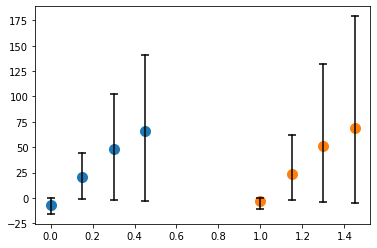

In [18]:
colors = ['tab:blue','tab:orange','tab:green']
location_ids = [163,214]
positions = list(range(0,len(location_ids)))
for n in list(range(0,len(location_ids))):
    rate = rates.loc[rates.year==2025]
    rate = rate.loc[rate.location_id == location_ids[n]]
    for i in list(range(0,len(rate))):
        plt.plot([positions[n] + 0.15 * i,positions[n]+ 0.15 * i],[rate['2.5%'].values[i],rate['97.5%'].values[i]],c='black')
    plt.scatter([positions[n], positions[n] + 0.15, positions[n] + 0.3, positions[n] + 0.45], rate['mean'],s=100,)
    plt.scatter([positions[n], positions[n] + 0.15, positions[n] + 0.3, positions[n] + 0.45], rate['2.5%'],s=50, marker='_', c='black')
    plt.scatter([positions[n], positions[n] + 0.15, positions[n] + 0.3, positions[n] + 0.45], rate['97.5%'],s=50, marker='_', c='black')
    

([<matplotlib.axis.XTick at 0x2b7652eadc18>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

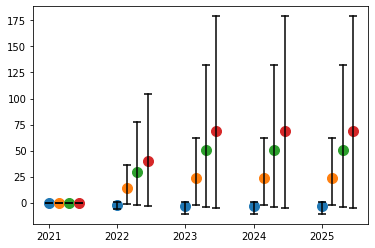

In [20]:
colors = ['tab:blue','tab:orange','tab:green']
location_id=214
for n in list(range(0,len(coverage_levels))):
    rate = rates.loc[rates.location_id==location_id]
    rate = rate.loc[rate.coverage_level == coverage_levels[n]]
    for i in list(range(0,len(rate))):
        plt.plot([years[i] + 0.15 * n,years[i]+ 0.15 * n],[rate['2.5%'].values[i],rate['97.5%'].values[i]],c='black')
    plt.scatter(list(np.array(years) + 0.15 * n), rate['mean'],s=100)
    plt.scatter(list(np.array(years) + 0.15 * n), rate['2.5%'],s=50, marker='_', c='black')
    plt.scatter(list(np.array(years) + 0.15 * n), rate['97.5%'],s=50, marker='_', c='black')
plt.xticks(years)

([<matplotlib.axis.XTick at 0x2b764f9d98d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

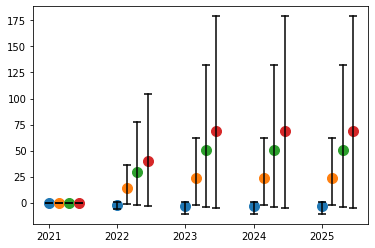

In [21]:
colors = ['tab:blue','tab:orange','tab:green']

for n in list(range(0,len(coverage_levels))):
    rate = rates.loc[rates.location_id==location_id]
    rate = rate.loc[rate.coverage_level == coverage_levels[n]]
    for i in list(range(0,len(rate))):
        plt.plot([years[i] + 0.15 * n,years[i]+ 0.15 * n],[rate['2.5%'].values[i],rate['97.5%'].values[i]],c='black')
    plt.scatter(list(np.array(years) + 0.15 * n), rate['mean'],s=100)
    plt.scatter(list(np.array(years) + 0.15 * n), rate['2.5%'],s=50, marker='_', c='black')
    plt.scatter(list(np.array(years) + 0.15 * n), rate['97.5%'],s=50, marker='_', c='black')
plt.xticks(years)

In [23]:
# note... want to restructure these plots to bar chart or scatter so that
# it does not appear like we are modeling partial years

def make_plots(location_id):
    plt.figure()
    colors = ['tab:blue','tab:orange','tab:green']

    env = (paf_dalys_deficiency * dalys).groupby('location_id').sum().reset_index()
    env = env.loc[env.location_id==location_id]
    env = env.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
    env['mean'] = env['mean'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000
    env['2.5%'] = env['2.5%'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000
    env['97.5%'] = env['97.5%'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000

    plt.plot(years, [env['mean'].values[0]] * len(years), color='grey')
    plt.fill_between(years, [env['2.5%'].values[0]] * len(years), [env['97.5%'].values[0]] * len(years), color='grey', alpha=0.1)

    for i in list(range(len(coverage_levels) - 1)):
        rate = rates.loc[rates.location_id==location_id]
        rate = rate.loc[rate.coverage_level == coverage_levels[i]]

        plt.plot(rate.year, rate['mean'],color=colors[i])
        plt.fill_between(rate.year, rate['2.5%'], rate['97.5%'], color=colors[i], alpha=0.1)

    location_name = l.loc[l.location_id==location_id]['location_name'].values[0]
    plt.title(f'DALYs Averted Due to Vitamin A Fortification \n Scale-up among Children Under Five in {location_name}')
    plt.xlabel('Year')
    plt.ylabel('DALYs per 100,000 person-years')
    plt.legend(['Total Vitamin A Deficiency Burden','20% coverage','50% coverage','80% coverage'])
    plt.xticks(years)

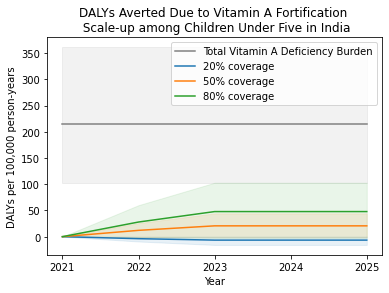

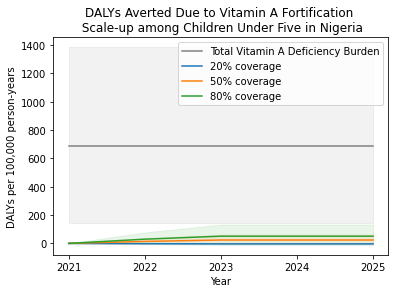

In [24]:
for location_id in location_ids:
    make_plots(location_id)

In [25]:
def weight_pif_by_dalys_and_population(dalys, years, pif_dalys_nofort, age_group_ids, location_ids, sex_ids):
    dalys_prepped = duplicate_over_simulation_years(dalys,years) 
    dalys_summed = dalys_prepped.groupby(['location_id','sex_id','age_group_id','year']).sum() 
    dalys_fracs = dalys_prepped / dalys_summed
    
    daly_weighted_pif = ((pif_dalys_nofort * dalys_fracs)
                         .groupby(['location_id','sex_id','age_group_id','year','coverage_level']).sum())
    
    pop = (get_population(location_id=location_ids,
                    sex_id=sex_ids,
                    age_group_id=age_group_ids,
                    gbd_round_id=6,
                    decomp_step='step4')
      .set_index(['location_id','sex_id','age_group_id'])
      .filter(['population']))
    pop = duplicate_over_simulation_years(pop, years).reset_index().set_index(['location_id','year','sex_id','age_group_id'])
    pop_sum = pop.groupby(['location_id','year']).sum()
    pop_frac = pop / pop_sum
    pop_frac_final = pd.DataFrame()
    for level in coverage_levels:
        pop_frac_level = pop_frac.copy()
        pop_frac_level['coverage_level'] = level
        pop_frac_final = pd.concat([pop_frac_final,pop_frac_level])
    pop_frac_final = pop_frac_final.reset_index().set_index(['location_id','year','age_group_id','sex_id','coverage_level'])

    daly_and_pop_weighted_pif = daly_weighted_pif.sort_index()
    pop_frac = pop_frac.reset_index().set_index(['location_id','sex_id','age_group_id','year']).sort_index()

    for i in list(range(0,1000)):
        daly_and_pop_weighted_pif[f'draw_{i}'] = daly_and_pop_weighted_pif[f'draw_{i}'] * pop_frac_final['population'].values
    daly_and_pop_weighted_pif = daly_and_pop_weighted_pif.groupby(['location_id','year','coverage_level']).sum().sort_index()
    return daly_and_pop_weighted_pif

In [26]:
daly_and_pop_weighted_pif = weight_pif_by_dalys_and_population(dalys, 
                                                               years, 
                                                               pif_dalys_nofort, 
                                                               age_group_ids, 
                                                               location_ids, 
                                                               sex_ids)
daly_and_pop_weighted_pif.head()

ValueError: operands could not be broadcast together with shapes (800,) (320,) 

In [ ]:
data = daly_and_pop_weighted_pif.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1).reset_index()
data = data.loc[data.year==2025].loc[data.coverage_level==0.8]
for loc in data.location_id.unique():
    p = data.loc[data.location_id==loc]
    plt.scatter([0], p['mean'])
plt.legend(data.location_id.unique())